# This work is baed on paper "A Neural Algorithm of Artistic Style" by "Leon A. Gatys, Alexander S. Ecker, Matthias Bethge"

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [31]:
# desired size of the image
imgsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
            transforms.Resize(imgsize),  #Scale imported image
            transforms.ToTensor()])      # Convert image to tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


#style_image = image_loader("./picasso.jpg")
#content_image = image_loader("./dancing.jpg")

style_image = image_loader("./style1.jpg")
content_image = image_loader("./content1.jpg")


assert style_image.size() == content_image.size()    

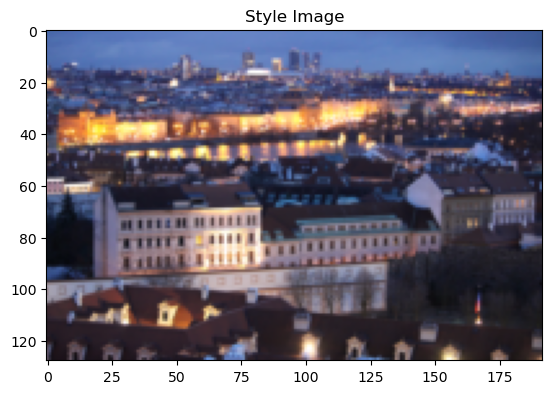

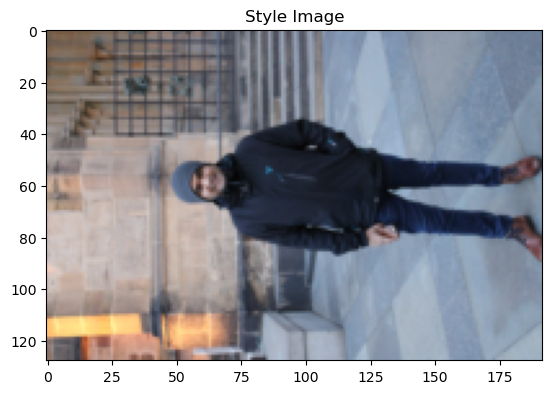

In [32]:
unloader = transforms.ToPILImage() # Reconvert into PIL image

#plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() # clone so that original tensor is unaltered
    image = image.squeeze(0)     # remove the dimension added during transformation
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)           # pause a little for plots to be updated

plt.figure()
imshow(style_image, title='Style Image')

plt.figure()
imshow(content_image, title='Style Image')


    
    
    


Content Loss

In [33]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # Target needs to be detached. This sud not vary with gradients

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [34]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a batch size (=1) 
    # b Number of feature maps
    # c, d Dimesnions of Feature map (n = c*d)

    features = input.view(a*b, c*d) # resize F_XL into \hat F_XL
    G = torch.mm(features, features.t()) # Gram product
    return G.div(a*b*c*d) # Normalise the gram matrix by the number of elements in feature maps

In [35]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self,input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Importing the model

In [36]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval() # vgg19 has features (convolution and maxpooling) and classifier (fully connected layers)

In [37]:
cnn_normalization_mean = torch.tensor([0.485,0.456,0.406])
cnn_normalization_std = torch.tensor([0.229,0.224,0.225])

In [38]:
# create a module to normalise input image so that it can be put easily to nn.sequntial
class Normalization(nn.Module):
    def __init__(self,mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)  # reshaping to C * 1 * 1 so that it can work with image that is B * C* H* W
        self.std = torch.tensor(std).view(-1,1,1)    # same as above

    def forward(self, img):
        return (img - self.mean)/self.std # normalise image       
        

In [39]:
# desired depth layers to compute content/style loss
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn,normalization_mean, normalization_std, 
                               style_img, content_img, 
                               content_layers = content_layers_default, style_layers=style_layers_default):
    normalization = Normalization(normalization_mean,normalization_std)
    content_losses =  []
    style_losses = []

    # Instantiate new model that is sequential, which we will design as per below
    model = nn.Sequential(normalization)

    i = 0  # increment for every conv layer
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False) #Inplace relu doesnot work with content and style losses
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer {}'.format(layer.__class__.__name__))


        model.add_module(name,layer)
        #print('name {}'.format(name))
        #print('layer {}'.format(layer))

        if name in content_layers:
            # add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            #print('model {}'.format(model))
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss
            #print(style_img.shape)
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            #print(style_loss)
            model.add_module('style_loss_{}'.format(i), style_loss)
            #print('model {}'.format(model))
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1,-1,-1):
        if isinstance(model[i],ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:i+1]

    return model, style_losses, content_losses   

        
    

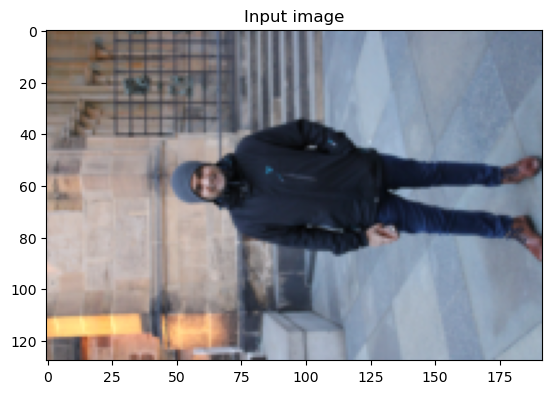

In [40]:
input_img = content_image.clone()
#input_img = torch.randn(content_img.data.size()) # white noise

plt.figure()
imshow(input_img, title='Input image')

In [41]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer    

In [42]:
def run_style_transfer(cnn,normalization_mean, normalization_std, content_image, style_image, input_img, num_steps = 300, style_weight = 1000000, content_weight=1):
    print("Building the style transfer model")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_image, content_image)
    input_img.requires_grad_(True) # input image takes the gradient not the model
    model.eval() # set model to evaluation mode so that dropout is switched off and normalisation works for whole data (mean/std based on full data)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    print ('Optimizing')
    run=[0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0,1) # tensor values of image to be within range 0 and 1

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print ('run {}'.format(run[0]))
                print ('Style loss : {:4f}  Content loss : {:4f}'.format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score
            
        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0,1)

    # Save the model parameters
    #torch.save(model.state_dict(),'model_neural_style_transfer.pth')
    
    return input_img            
        
    
    

Run the algorithm

Building the style transfer model
Optimizing
run 50
Style loss : 81.803635  Content loss : 17.222845

run 100
Style loss : 38.556698  Content loss : 18.216154

run 150
Style loss : 26.242575  Content loss : 18.272879

run 200
Style loss : 18.675335  Content loss : 18.163010

run 250
Style loss : 13.489725  Content loss : 17.936918

run 300
Style loss : 9.877030  Content loss : 17.558424



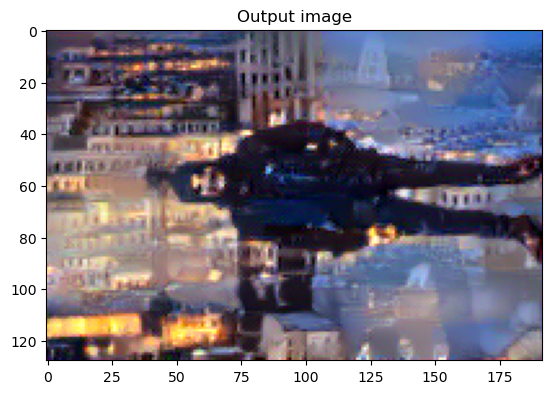

In [43]:
output = run_style_transfer(cnn,cnn_normalization_mean, cnn_normalization_std, content_image, style_image, input_img)

plt.figure()
imshow(output, title = 'Output image')

plt.show()

NameError: name 'model' is not defined